In [9]:
import sys
sys.path.append('/workspace/Documents')

import argparse
import os
import sys
import subprocess
import nibabel as nb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import Diffusion_denoising_thin_slice.Build_lists.Build_list as Build_list
import Diffusion_denoising_thin_slice.functions_collection as ff
import Diffusion_denoising_thin_slice.Data_processing as Data_processing

In [10]:
build_sheet =  Build_list.Build(os.path.join('/mnt/camca_NAS/denoising/Patient_lists/fixedCT_static_simulation_train_test_gaussian_NAS.xlsx'))
_,patient_id_list,patient_subid_list,random_num_list, condition_list, x0_list = build_sheet.__build__(batch_list = [5]) 
n = ff.get_X_numbers_in_interval(total_number = patient_id_list.shape[0],start_number = 0,end_number = 1, interval = 2)

In [36]:
avg_slice = False

results = []
for i in range(0,1):
    patient_id = patient_id_list[n[i]]
    patient_subid = patient_subid_list[n[i]]
    random_n = random_num_list[n[i]]
    print(patient_id, patient_subid, random_n)

    gt_file = os.path.join('/mnt/camca_NAS/denoising/models/unsupervised_gaussian_2D_mean_beta10/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch56_1/gt_img.nii.gz')
    gt_img = nb.load(gt_file).get_fdata()
    # process gt
    shape = gt_img.shape
    gt_img_new = np.zeros((gt_img.shape[0], gt_img.shape[1], gt_img.shape[2]-2))
    for i in range(1, gt_img.shape[2]-1):
        gt_img_new[:,:,i-1] = np.mean(gt_img[:,:,i-1:i+2], axis = 2)
    gt_img = np.copy(gt_img_new) if avg_slice else np.copy(gt_img)
    gt_img_brain = Data_processing.cutoff_intensity(gt_img, cutoff_low=-100, cutoff_high=100)

    condition_file = os.path.join('/mnt/camca_NAS/denoising/models/unsupervised_gaussian_2D_mean_beta10/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch56_1/condition_img.nii.gz')
    condition_img = nb.load(condition_file).get_fdata() if avg_slice == False else nb.load(condition_file).get_fdata()[:,:,1:shape[2]-1]
    condition_img_brain = Data_processing.cutoff_intensity(condition_img, cutoff_low=-100, cutoff_high=100)

    supervised_file = os.path.join('/mnt/camca_NAS/denoising/models/supervised_possion_2D/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch46_1/pred_img.nii.gz')
    supervised_img = nb.load(supervised_file).get_fdata() if avg_slice == False else nb.load(supervised_file).get_fdata()[:,:,1:shape[2]-1]
    supervised_img_brain = Data_processing.cutoff_intensity(supervised_img, cutoff_low=-100, cutoff_high=100)

    ddpm_file = os.path.join('/mnt/camca_NAS/denoising/models/unsupervised_gaussian_2D_mean_beta10/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch56_1/pred_img.nii.gz')
    ddpm_img = nb.load(ddpm_file).get_fdata() if avg_slice == False else nb.load(ddpm_file).get_fdata()[:,:,1:shape[2]-1]
    ddpm_img_brain = Data_processing.cutoff_intensity(ddpm_img, cutoff_low=-100, cutoff_high=100)

    ddpm_beta0_file = os.path.join('/mnt/camca_NAS/denoising/models/unsupervised_gaussian_2D_mean_beta0/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch61_1/pred_img.nii.gz')
    ddpm_beta0_img = nb.load(ddpm_beta0_file).get_fdata() if avg_slice == False else nb.load(ddpm_beta0_file).get_fdata()[:,:,1:shape[2]-1]
    ddpm_beta0_img_brain = Data_processing.cutoff_intensity(ddpm_beta0_img, cutoff_low=-100, cutoff_high=100)


    ddpm_avg_20_file = os.path.join('/mnt/camca_NAS/denoising/models/unsupervised_gaussian_2D_mean_beta10/pred_images', patient_id, patient_subid,'random_'+str(random_n), 'epoch56avg/pred_img_scans20.nii.gz')
    ddpm_avg_20_img = nb.load(ddpm_avg_20_file).get_fdata() if avg_slice == False else nb.load(ddpm_avg_20_file).get_fdata()[:,:,1:shape[2]-1]
    ddpm_avg_20_img_brain = Data_processing.cutoff_intensity(ddpm_avg_20_img, cutoff_low=-100, cutoff_high=100)

    # compare brain region
    mae_brain_motion, _, rmse_brain_motion, _, ssim_brain_motion,psnr_brain_motion = ff.compare(condition_img_brain, gt_img_brain, cutoff_low = 0, cutoff_high = 100)
    mae_brain_supervised, _, rmse_brain_supervised, _, ssim_brain_supervised,psnr_brain_supervised = ff.compare(supervised_img_brain, gt_img_brain, cutoff_low = 0, cutoff_high = 100)

    mae_brain_ddpm, _, rmse_brain_ddpm, _, ssim_brain_ddpm,psnr_brain_ddpm = ff.compare(ddpm_img_brain, gt_img_brain, cutoff_low = 0, cutoff_high = 100)
    mae_brain_ddpm_beta0, _, rmse_brain_ddpm_beta0, _, ssim_brain_ddpm_beta0,psnr_brain_ddpm_beta0 = ff.compare(ddpm_beta0_img_brain, gt_img_brain, cutoff_low = 0, cutoff_high = 100)
    mae_brain_ddpm_avg_20, _, rmse_brain_ddpm_avg_20, _, ssim_brain_ddpm_avg_20,psnr_brain_ddpm_avg_20 = ff.compare(ddpm_avg_20_img_brain, gt_img_brain, cutoff_low = 0, cutoff_high = 100)

    print('motion:', mae_brain_motion, rmse_brain_motion, ssim_brain_motion, psnr_brain_motion)
    print('mae_brain_supervised:', mae_brain_supervised, rmse_brain_supervised, ssim_brain_supervised, psnr_brain_supervised)
    print('ddpm:', mae_brain_ddpm, rmse_brain_ddpm, ssim_brain_ddpm, psnr_brain_ddpm)
    print('ddpm_beta0:', mae_brain_ddpm_beta0, rmse_brain_ddpm_beta0, ssim_brain_ddpm_beta0, psnr_brain_ddpm_beta0)
    print('ddpm_avg_20:', mae_brain_ddpm_avg_20, rmse_brain_ddpm_avg_20, ssim_brain_ddpm_avg_20, psnr_brain_ddpm_avg_20)

00214841 0000455418 0
motion: 5.288287600577581 6.655150643915416 0.8578530735685175 23.53684219047061
mae_brain_supervised: 2.386824220465911 3.1267599197213762 0.9641675460319427 30.098109273401647
ddpm: 3.5437302405885074 4.59048795311521 0.9167420595691995 26.762822959921323
ddpm_beta0: 3.9497061397143067 5.067152985215304 0.9065719425869297 25.904719669734888
ddpm_avg_20: 2.1354749591940543 2.9224352184774873 0.9645959099100428 30.685102141009907


In [37]:
# compare brain region
x= 257# case0:246
y = 249 # case 0: 214

condition_img_brain2 = condition_img_brain[x-50: x+50, y-50: y+50, :]
gt_img_brain2 = gt_img_brain[x-50: x+50, y-50: y+50, :]
supervised_img_brain2 = supervised_img_brain[x-50: x+50, y-50: y+50, :]
ddpm_img_brain2 = ddpm_img_brain[x-50: x+50, y-50: y+50, :]
ddpm_beta0_img_brain2 = ddpm_beta0_img_brain[x-50: x+50, y-50: y+50, :]
ddpm_avg_20_img_brain2 = ddpm_avg_20_img_brain[x-50: x+50, y-50: y+50,:]

gt_img_brain2 = np.clip(gt_img_brain2, 0, 100)
condition_img_brain2 = np.clip(condition_img_brain2, 0, 100)
supervised_img_brain2 = np.clip(supervised_img_brain2, 0, 100)
ddpm_img_brain2 = np.clip(ddpm_img_brain2, 0, 100)
ddpm_beta0_img_brain2 = np.clip(ddpm_beta0_img_brain2, 0, 100)
ddpm_avg_20_img_brain2 = np.clip(ddpm_avg_20_img_brain2, 0, 100)

print('print average of each of above images: ', np.mean(gt_img_brain2), np.mean(condition_img_brain2),np.mean(supervised_img_brain2), np.mean(ddpm_img_brain2), np.mean(ddpm_beta0_img_brain2), np.mean(ddpm_avg_20_img_brain2))

mae_brain_supervised2, _, rmse_brain_supervised2, _, ssim_brain_supervised2,psnr_brain_supervised2 = ff.compare(supervised_img_brain2, gt_img_brain2, cutoff_low = 0, cutoff_high = 100)
mae_brain_ddpm2, _, rmse_brain_ddpm2, _, ssim_brain_ddpm2,psnr_brain_ddpm2 = ff.compare(ddpm_img_brain2, gt_img_brain2, cutoff_low = 0, cutoff_high = 100)
mae_brain_ddpm_beta02, _, rmse_brain_ddpm_beta02, _, ssim_brain_ddpm_beta02,psnr_brain_ddpm_beta02 = ff.compare(ddpm_beta0_img_brain2, gt_img_brain2, cutoff_low = 0, cutoff_high = 100)
mae_brain_ddpm_avg_202, _, rmse_brain_ddpm_avg_202, _, ssim_brain_ddpm_avg_202,psnr_brain_ddpm_avg_202 = ff.compare(ddpm_avg_20_img_brain2, gt_img_brain2, cutoff_low = 0, cutoff_high = 100)
print('supervised2:', mae_brain_supervised2, rmse_brain_supervised2, ssim_brain_supervised2, psnr_brain_supervised2)
print('ddpm2:', mae_brain_ddpm2, rmse_brain_ddpm2, ssim_brain_ddpm2, psnr_brain_ddpm2)
print('ddpm_beta02:', mae_brain_ddpm_beta02, rmse_brain_ddpm_beta02, ssim_brain_ddpm_beta02, psnr_brain_ddpm_beta02)
print('ddpm_avg_202:', mae_brain_ddpm_avg_202, rmse_brain_ddpm_avg_202, ssim_brain_ddpm_avg_202, psnr_brain_ddpm_avg_202)



print average of each of above images:  24.65276413689698 24.724014275512694 24.30498973535914 25.398599547821284 25.958409021338205 25.359562880525473
supervised2: 2.259120786288815 2.9048026807432126 0.8799557145015287 30.737667265988605
ddpm2: 3.4977156679946084 4.4309272202802825 0.7829115939801848 27.070107667344523
ddpm_beta02: 4.067190215977279 5.154836364050513 0.7368255925446756 25.755702329502057
ddpm_avg_202: 1.9600014985830918 2.5168455119215407 0.9216200036842327 31.982868826729216


(512, 512, 20)
motion:  5.388951883418051 6.771968992286265 0.7127473747080338 23.38570078240736
supervised eroded: 2.245359239411951 2.889135895544811 0.9263300410725627 30.784640597541937
ddpm eroded: 3.4249194213662397 4.327620239297115 0.8355185240445725 27.275017135543322
ddpm_beta0 eroded: 3.850986352617611 4.874664695214851 0.8114919403328676 26.24110503941603
ddpm_avg_20 eroded: 1.929306906497564 2.4788717059777503 0.9397732491580998 32.1149189912892


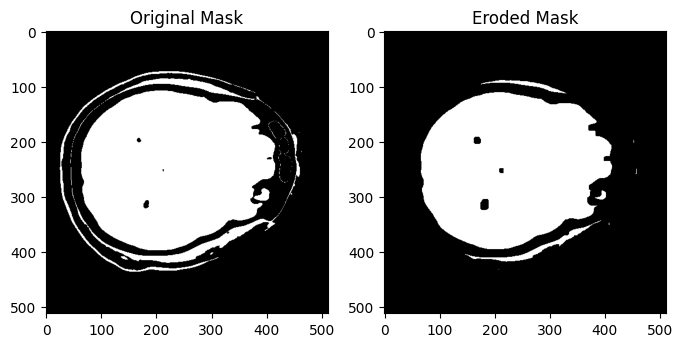

In [38]:
from scipy.ndimage import binary_erosion, generate_binary_structure
# erode
mask = np.zeros(gt_img_brain.shape, dtype=bool)
mask[(gt_img_brain>0) & (gt_img_brain < 100)] = 1
print(mask.shape)
structure = np.ones((6,6))
mask_eroded = np.zeros_like(mask, dtype=bool)
for i in range(mask.shape[2]):
    mask_eroded[:, :, i] = binary_erosion(mask[:, :, i], structure=structure, iterations=1)



# plot side by side
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask[:, :, 0], cmap='gray')
plt.title('Original Mask')
plt.subplot(1, 2, 2)
plt.imshow(mask_eroded[:, :, 0], cmap='gray')
plt.title('Eroded Mask')

# mae
mae_brain_motion_eroded, _, rmse_brain_motion_eroded, _, ssim_brain_motion_eroded,psnr_brain_motion_eroded = ff.compare(condition_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
mae_brain_supervised_eroded, _, rmse_brain_supervised_eroded, _, ssim_brain_supervised_eroded,psnr_brain_supervised_eroded = ff.compare(supervised_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
mae_brain_ddpm_eroded, _, rmse_brain_ddpm_eroded, _, ssim_brain_ddpm_eroded,psnr_brain_ddpm_eroded = ff.compare(ddpm_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
mae_brain_ddpm_beta0_eroded, _, rmse_brain_ddpm_beta0_eroded, _, ssim_brain_ddpm_beta0_eroded,psnr_brain_ddpm_beta0_eroded = ff.compare(ddpm_beta0_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)
mae_brain_ddpm_avg_20_eroded, _, rmse_brain_ddpm_avg_20_eroded, _, ssim_brain_ddpm_avg_20_eroded,psnr_brain_ddpm_avg_20_eroded = ff.compare(ddpm_avg_20_img_brain[mask_eroded==1], gt_img_brain[mask_eroded==1], cutoff_low = 0, cutoff_high = 100)

print('motion: ', mae_brain_motion_eroded, rmse_brain_motion_eroded, ssim_brain_motion_eroded, psnr_brain_motion_eroded)
print('supervised eroded:', mae_brain_supervised_eroded, rmse_brain_supervised_eroded, ssim_brain_supervised_eroded, psnr_brain_supervised_eroded)
print('ddpm eroded:', mae_brain_ddpm_eroded, rmse_brain_ddpm_eroded, ssim_brain_ddpm_eroded, psnr_brain_ddpm_eroded)
print('ddpm_beta0 eroded:', mae_brain_ddpm_beta0_eroded, rmse_brain_ddpm_beta0_eroded, ssim_brain_ddpm_beta0_eroded, psnr_brain_ddpm_beta0_eroded)
print('ddpm_avg_20 eroded:', mae_brain_ddpm_avg_20_eroded, rmse_brain_ddpm_avg_20_eroded, ssim_brain_ddpm_avg_20_eroded, psnr_brain_ddpm_avg_20_eroded)


In [11]:
affine = nb.load(gt_file).affine

gt_img_brain2 = np.copy(gt_img_brain)

gt_img_brain2[gt_img_brain <= 10] = 0
gt_img_brain2[gt_img_brain >= 90] = 0
gt_img_brain2[(gt_img_brain > 10) & (gt_img_brain < 90)] = 1

nb.save(nb.Nifti1Image(gt_img_brain2, affine), os.path.join('/mnt/camca_NAS/denoising/binary.nii.gz'))

In [12]:
affine = nb.load(gt_file).affine

# save gt_img_brain
nb.save(nb.Nifti1Image(gt_img_brain, affine), os.path.join('/mnt/camca_NAS/denoising/gt.nii.gz'))

# save condition_img_brain
nb.save(nb.Nifti1Image(condition_img_brain, affine), os.path.join('/mnt/camca_NAS/denoising/condition.nii.gz'))

# save supervised_img_brain
nb.save(nb.Nifti1Image(supervised_img_brain, affine), os.path.join('/mnt/camca_NAS/denoising/supervised.nii.gz'))
nb.save(nb.Nifti1Image(np.abs(supervised_img_brain-gt_img_brain), affine), os.path.join('/mnt/camca_NAS/denoising/supervised_diff.nii.gz'))

# save ddpm_img_brain
nb.save(nb.Nifti1Image(ddpm_img_brain, affine), os.path.join('/mnt/camca_NAS/denoising/ddpm.nii.gz'))

# save ddpm_avg_20_img_brain
nb.save(nb.Nifti1Image(ddpm_avg_20_img_brain, affine), os.path.join('/mnt/camca_NAS/denoising/ddpm_avg_20.nii.gz'))
nb.save(nb.Nifti1Image(np.abs(ddpm_avg_20_img_brain-gt_img_brain), affine), os.path.join('/mnt/camca_NAS/denoising/ddpm_avg_20_diff.nii.gz'))

nb.save(nb.Nifti1Image(np.abs(condition_img_brain-gt_img_brain), affine), os.path.join('/mnt/camca_NAS/denoising/condition_diff.nii.gz'))

nb.save(nb.Nifti1Image(np.abs(ddpm_img_brain-gt_img_brain), affine), os.path.join('/mnt/camca_NAS/denoising/ddpm_diff.nii.gz'))

